In [1]:
using DifferentialEquations
using ForwardDiff
using DiffResults
using DiffEqSensitivity
using Statistics
using Random
using LinearAlgebra
using DataFrames
using CSV
using Dierckx
using Plots
using StatsPlots
using LaTeXStrings

┌ Warning: `ODELocalSensitivityProblem(args...; kwargs...)` is deprecated, use `ODEForwardSensitivityProblem(args...; kwargs...)` instead.
│   caller = top-level scope at In[2]:16
└ @ Core In[2]:16


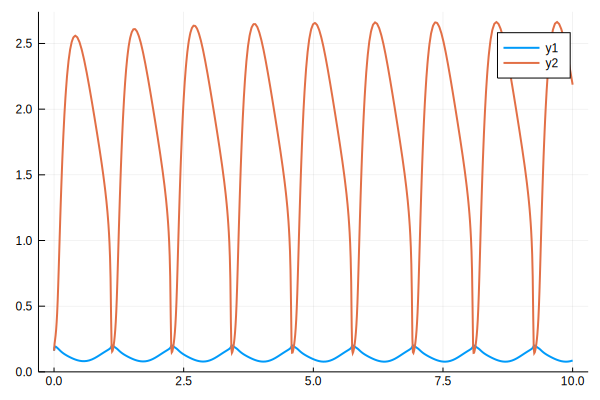

In [2]:
# Yeast glycolysis model
function f_glyc(dx, x, p, t)
    x1, x2, x3, x4, x5, x6, x7 = x
    J0, k1, K1, q, k2, N, k6, k3, A, k4, κ, k5, ψ, k = p 
    dx[1] = J0 - k1*x1*x6 / (1+(x6/K1)^q)
    dx[2] = 2*k1*x1*x6 / (1+(x6/K1)^q) - k2*x2*(N-x5) - k6*x2*x5
    dx[3] = k2*x2*(N-x5) - k3*x3*(A-x6)
    dx[4] = k3*x3*(A-x6) - k4*x4*x5 - κ*(x4-x7)
    dx[5] = k2*x2*(N-x5) - k4*x4*x5 - k6*x2*x5
    dx[6] = -2*k1*x1*x6 / (1+(x6/K1)^q) + 2*k3*x3*(A-x6) - k5*x6
    dx[7] = ψ*κ*(x4-x7) - k*x7
end
p = [2.5, 100., 0.52, 4., 6., 1., 12., 16., 4., 100., 13., 1.28, 0.1, 1.8]
x0 = [0.501, 1.955, 0.198, 0.148, 0.161, 0.161, 0.064]
tspan = (0., 10.)
prob_glyc = ODELocalSensitivityProblem(f_glyc, x0, tspan, p)

sol_glyc = solve(prob_glyc, alg_hints=[:stiff], saveat=0.01)
x_glyc, dp_glyc = extract_local_sensitivities(sol_glyc)

lab = [L"J_0", L"k_1", L"K_1", L"q", L"k_2", L"N", L"k_6", L"k_3", L"A", L"k_4", L"\kappa", L"k_5", L"\psi", L"k"]
σ = 0.1 * std(x_glyc, dims=2)
cov_ϵ = Diagonal(σ[5:6])
dp = dp_glyc
cols = 5:6

plot(sol_glyc.t, x_glyc[5:6, :]', lw=2)

In [ ]:
# Cell apoptosis model
function f_apop(dx, x, p, t)
    x1, x2, x3, x4, x5, x6, x7, x8 = x
    k1, kd1, kd2, k3, kd3, kd4, k5, kd5, kd6 = p
    dx[1] = -k1*x4*x1 + kd1*x5
    dx[2] = kd2*x5 - k3*x2*x3 + kd3*x6 + kd4*x6
    dx[3] = -k3*x2*x3 + kd3*x6
    dx[4] = kd4*x6 - k1*x4*x1 + kd1*x5 - k5*x7*x4 + kd5*x8 + kd2*x5
    dx[5] = -kd2*x5 + k1*x4*x1 - kd1*x5
    dx[6] = -kd4*x6 + k3*x2*x3 - kd3*x6
    dx[7] = -k5*x7*x4 + kd5*x8 + kd6*x8
    dx[8] = k5*x7*x4 - kd5*x8 - kd6*x8
end
cscale = 1e5; tscale = 3600.;
p = [2.67e-9*cscale, 1e-2, 8e-3, 6.8e-8*cscale, 5e-2, 1e-3, 7e-5*cscale, 1.67e-5, 1.67e-4] * tscale
# x0 = [1.34e5, 1e5, 2.67e5, 0.0, 0.0, 0.0, 2.9e3, 0.0] / cscale  # death
x0 = [1.34e5, 1e5, 2.67e5, 0.0, 0.0, 0.0, 2.9e4, 0.0] / cscale  # survival
tspan = (0.0, 60.0)
prob_apop = ODELocalSensitivityProblem(f_apop, x0, tspan, p)

sol_apop = solve(prob_apop, alg_hints=[:stiff], saveat=0.1)
x_apop, dp_apop = extract_local_sensitivities(sol_apop)

lab = [L"k_1", L"k_{d1}", L"k_{d2}", L"k_3", L"k_{d3}", L"k_{d4}", L"k_5", L"k_{d5}", L"k_{d6}"]
σ = 0.05 * std(x_apop, dims=2)
cov_ϵ = σ[4]
dp = dp_apop
cols = 4:4

plot(sol_apop.t, x_apop[4,:], lw=2)

In [3]:
Nt = length(dp[1][1,:])
Nstate = length(dp[1][:,1])
Nparam = length(dp[:,1])
F = zeros(Float64, Nparam, Nparam)
# G = zeros(Float64, Nstate, Nparam)
perm = vcat(1, sort(rand(2:Nt-1, Nt÷5)), Nt)

for i in perm
    S = reshape(dp[1][:,i], (Nstate,1))
    for j = 2:Nparam
        S = hcat(S, reshape(dp[j][:,i], (Nstate,1)))
    end
    F += S[cols,:]' * inv(cov_ϵ) * S[cols,:]
#     if (i == 1)
#         G = S
#     else
#         G = vcat(G, S)
#     end
end

In [ ]:
# cor_G = cor(G, dims=1)
# heatmap(cor_G, aspect_ratio=1, zcolor=(-1,1))

In [4]:
# correlation matrix
C = inv(F)
R = ones(size(C))
R = [C[i,j]/sqrt(C[i,i]*C[j,j]) for i = 1:size(C)[1], j = 1:size(C)[1]]
heatmap(R, xlims=(0.5,size(R)[1]+0.5), aspect_ratio = 1, color = :inferno, clims = (-1, 1),
        xticks = (1:1:size(C)[1], lab), xtickfont = font(14, "Times"),
        yticks = (1:1:size(C)[1], lab), ytickfont = font(14, "Times"), fmt = :png, dpi=300)
savefig("correlation_matrix")

In [ ]:
abs.(R) .> 0.99

In [ ]:
# Yeast glycolysis model
lowerbound = sqrt.(diag(inv(F)))
for i = 1:length(lab)
    println(lab[i], '\t', lowerbound[i])
end

In [ ]:
# Cell apoptosis model
lowerbound = sqrt.(diag(inv(F))) / tscale
lowerbound[1:3:7] = lowerbound[1:3:7] / cscale
for i = 1:length(lab)
    println(lab[i], '\t', lowerbound[i])
end

In [ ]:
# Cell apoptosis model
for i = 1:Nparam
    println(eigvals(F)[i])
    println(eigvecs(F)[:,i])
    println('\n')
end

# death
# bar(eigvecs(F)[:,1:6], ylabel = "FIM null eigenvector coefficients", ytickfont = font(12, "Times"),
#     xticks = (1:1:size(C)[1], lab), xtickfont = font(12, "Courier"),
#     legendfontsize = 12, label = [L"null_1" L"null_2" L"null_3" L"null_4" L"null_5" L"null_6"], fmt = :png,
#     legend=:topright, dpi=300)

# Survival
bar(eigvecs(F)[:,1:6], ylabel = "FIM null eigenvector coefficients", ytickfont = font(12, "Times"),
    xticks = (1:1:size(C)[1], lab), xtickfont = font(12, "Courier"),
    legendfontsize = 12, label = [L"null_1" L"null_2" L"null_3" L"null_4" L"null_5" L"null_6"], fmt = :png,
    legend=:topright, dpi=300)
savefig("nulleigen_apop")